## Orphan molecule formation during bulk mixed-template PCR

Orphan molecules can be formed during bulk mixed-template PCR. This can be thought of as a diffusion process where orphans molecules are diffused away from real molecules and assume new (CB, UMI).

One mechanism is priming by incomplete PCR extension products from previous cycles, in particular, during the later stages when the reaction rate becomes primer-limited. If orphan molecules are formed via this mechanism, then we expect an orphan (CB, UMI, gene) to have a non-orphan parent. The most likely candidates for parents are:

- (CB, UMI, gene') where gene' is different from gene. In this case, priming is driven by micro-homologies between gene and gene'.

- (CB', UMI', gene) where gene is the same and CB' and UMI' are arbitrary. Here, CB' and UMI' do not need to be complementary to CB and UMI. A bubble will form around the barcode region and the 5' priming end is determined by complementarity between transcript sequences.

The latter process, which in all likelihood is the dominant process in primer-depleted cycles, is unobservable since the formed molecule will be _absorbed_ by the parent and are not orphans.

Another mechanism is priming by _unused barcoded capture oligos_. This mechanism is also difficult to observe directly.

In this notebook,

- We examine micro-homology driven mechanism of chimera formation by incomplete PCR extension products directly.
- We show that orphan molecules are much more likely to be assigned to cells that do not express a gene to begin with. 
- We show that libraries produced with higher bulk PCR cycles are more likely to produce orphan molecules.
- We show that for each gene, there is a positive correlation between the fraction of orphan molecules and the total density of non-orphan molecules (evidence for diffusion model).

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import editdistance
import pandas as pd
import itertools
import operator
from bisect import bisect_left, bisect_right
from commons import *

leven = editdistance.bycython.eval

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

## Orphan molecules and PCR cycles

In [2]:
pcr_cycles = [
    13,
    10]

h5_paths = [
    '/Users/mehrtash/Data/PCL/RA_1708_1/molecule_info.h5',
    '/Users/mehrtash/Data/PCL/RA_1708_2/molecule_info.h5']

In [ ]:
mol_info_list = [MoleculeInfo(h5_path, None) for h5_path in h5_paths]

In [281]:
# select a range of barcodes
top_cells = 2000
full_count_stats_list = []
gene_index_sorted_by_expression_list = []
cell_barcode_set_list = []

for mol_info in mol_info_list:
    cell_barcode_set = set(
        map(operator.itemgetter(0),
            sorted(mol_info.total_umi_per_barcode_list, key=operator.itemgetter(1), reverse=True)[:top_cells]))

    # obtain full UMI count statistics
    full_count_stats = get_full_umi_count_statistics(
        cell_barcode_set, mol_info.gene_array, mol_info.reads_array, mol_info.barcode_array)

    gene_index_sorted_by_expression = get_gene_index_sorted_by_expression(full_count_stats)
    gene_index_sorted_by_expression.remove(mol_info.unmappable_gene_idx)
    
    full_count_stats_list.append(full_count_stats)
    gene_index_sorted_by_expression_list.append(gene_index_sorted_by_expression)
    cell_barcode_set_list.append(cell_barcode_set)

In [282]:
def downsample_counts(counts, p):
    downsampled_counts = [np.random.binomial(c, p) for c in counts]
    return [c for c in downsampled_counts if c > 0]

In [378]:
gene_index = gene_index_sorted_by_expression_list[0][8]
print(mol_info_list[0].gene_names_array[gene_index])

counts_list = [full_count_stats_list[0][gene_index],
               full_count_stats_list[1][gene_index]]
total_reads = [np.sum(counts) for counts in counts_list]

b'DMD'


In [436]:
p = 0.467
np.mean(downsample_counts(counts_list[0], p))

3.1990645463049581

In [437]:
np.mean(counts_list[1])

3.1872093988708072

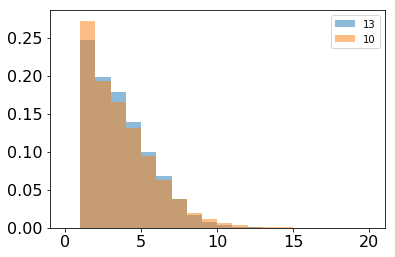

In [439]:
_ = plt.hist(downsample_counts(counts_list[0], p),
             bins=20, range=(0, 20), density=True, alpha=0.5, label=str(pcr_cycles[0]))
_ = plt.hist(counts_list[1], bins=20, range=(0, 20), density=True, alpha=0.5, label=str(pcr_cycles[1]))
plt.legend()

Notes:

- There is significant difference between FSD of different genes between the two experiments. Each gene requires a different downsampling rate to align mean FSD between the two experiments.

- The experiment with fewer PCR cycles seems to have produced more orphan molecules, but this is confounded by the fact the low PCR experiment had almost 2x more UMIs per cell. One needs to compare the qPCR curves.

## Orphan molecules and expression

In [2]:
mol_info = MoleculeInfo('/Users/mehrtash/Data/10x/pbmc4k_molecule_info.h5', None)

In [3]:
min_umi_count = 200
max_umi_count = 80000
cell_barcode_set = {barcode for barcode, total_umi in mol_info.total_umi_per_barcode.items()
                    if min_umi_count <= total_umi <= max_umi_count}

In [4]:
full_count_stats = get_full_umi_count_statistics(
    cell_barcode_set, mol_info.gene_array, mol_info.reads_array, mol_info.barcode_array)

gene_index_sorted_by_expression = get_gene_index_sorted_by_expression(full_count_stats)

In [5]:
from typing import Tuple

barcode_start_indices = []
sorted_barcodes = []
for barcode, records in itertools.groupby(enumerate(mol_info.barcode_array), operator.itemgetter(1)):
    first_index = next(records)[0]
    barcode_start_indices.append(first_index)
    sorted_barcodes.append(barcode)
barcode_start_indices.append(len(mol_info.barcode_array))
barcode_to_index_dict = {barcode: index for index, barcode in enumerate(sorted_barcodes)}

def get_barcode_index_range(barcode: int) -> Tuple[int, int]:
    barcode_index = barcode_to_index_dict[barcode]
    return (barcode_start_indices[barcode_index], barcode_start_indices[barcode_index + 1])

In [6]:
from collections import Counter
from scipy.signal import savgol_filter

def get_gene_props_for_barcode(barcode, gene_index, min_family_size, mol_info):
    barcode_start, barcode_end = get_barcode_index_range(barcode)
    barcode_genes = mol_info.gene_array[barcode_start:barcode_end]
    barcode_reads = mol_info.reads_array[barcode_start:barcode_end]
    cond = (barcode_reads >= min_family_size) & (barcode_genes == gene_index)
    
    total_expression = np.sum(cond)
    mean_family_size = np.mean(barcode_reads[cond]) if total_expression > 0 else np.nan
    
    return total_expression, mean_family_size


def get_family_size_expression(cell_barcode_set, gene_index, min_family_size, mol_info):
    total_expression_list = []
    mean_family_size_list = []
    for barcode in cell_barcode_set:
        total_expression, mean_family_size = get_gene_props_for_barcode(
            barcode, gene_index, min_family_size, mol_info)
        total_expression_list.append(total_expression)
        mean_family_size_list.append(mean_family_size)
    return total_expression_list, mean_family_size_list

In [32]:
gene_index_sorted_by_expression[5]

11106

b'EEF1A1'


/Users/mehrtash/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mehrtash/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mehrtash/anaconda3/lib/python3.6/site-packages/scipy/signal/_savitzky_golay.py:187: RankWarning: Polyfit may be poorly conditioned
  xx_edge, polyorder)
/Users/mehrtash/anaconda3/lib/python3.6/site-packages/scipy/signal/_savitzky_golay.py:187: RankWarning: Polyfit may be poorly conditioned
  xx_edge, polyorder)


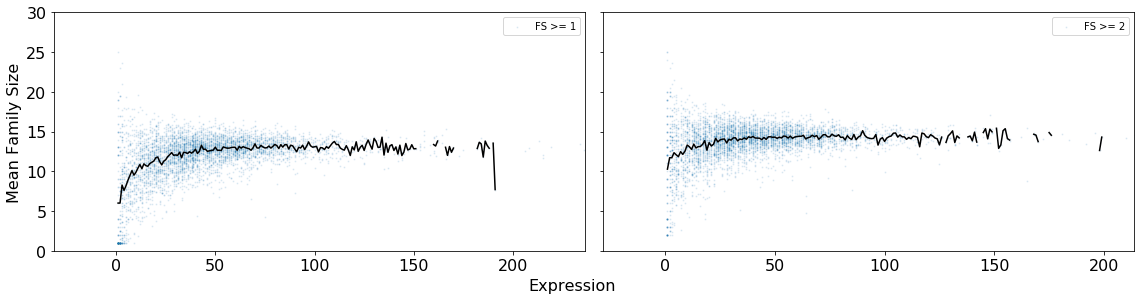

In [31]:
gene_index = gene_index_sorted_by_expression[5]
print(mol_info.gene_names_array[gene_index])
gene_name = mol_info.gene_names_array[gene_index].decode('ascii')

min_family_size_list = [1, 2]

axs = plt.subplots(ncols=len(min_family_size_list), sharey=True, figsize=(16, 4))[1]

for n, (min_family_size, ax) in enumerate(zip(min_family_size_list, axs)):
    total_expression_list, mean_family_size_list = get_family_size_expression(
        cell_barcode_set, gene_index, min_family_size, mol_info)
    
    gene_expr_fs_pair = [(expr, fs) for expr, fs in zip(total_expression_list, mean_family_size_list) if expr > 0]
    gene_expr_fs_pair = sorted(gene_expr_fs_pair, key=operator.itemgetter(0))
    max_expr = np.max(list(map(operator.itemgetter(0), gene_expr_fs_pair)))
    expr_list = []
    average_fs_list = []
    for expr in range(1, max_expr + 1):
        expr_list.append(expr)
        fs_list = [item[1] for item in gene_expr_fs_pair if item[0] == expr]
        average_fs_list.append(np.mean(fs_list))    
    average_fs_smooth = savgol_filter(average_fs_list, 3, 1)

    ax.scatter(total_expression_list, mean_family_size_list, alpha=0.1, s=1,
               label=f'FS >= {min_family_size}')
    ax.plot(expr_list, average_fs_list, color='black')
    if n == 0:
        ax.set_ylabel('Mean Family Size', fontsize=16)
    scl = max_expr
    ax.set_xlim((-0.1*scl, 0.75*scl))
    ax.set_ylim((0, 30))
    ax.legend(loc='upper right')
    
plt.suptitle('Expression', fontsize=16, y=0.02)
plt.tight_layout()
# plt.savefig(f'./plots/pbmc4k_family_size_expression_{gene_name}.pdf')